# Imports, paths, dataset

In [1]:
from ddsp import DDSP, AudioDataset, CLAPLoss
from ddsp.utils import find_checkpoint
from ddsp.callbacks import BetaWarmupCallback
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

from IPython.display import display
from IPython.display import Audio

from torch.utils.data import DataLoader, random_split
import lightning as L
import torch
torch.set_float32_matmul_precision('medium')
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.set_default_device('cuda')

from random import randint

import os
import shutil

# Model parameters
# model_name = 'liget'
model_name = 'drums'
fs = 44100
n_signal = 1.5 * fs # 1.5 seconds
training_path_root = '/home/btadeusz/code/ddsp_vae/training/seven-manifolds'
models_path_root = '/home/btadeusz/code/ddsp_vae/models/seven-manifolds'
# dataset_path = '/mnt/mariadata/datasets/seven_manifolds/liget'
dataset_path = '/mnt/mariadata/datasets/seven_manifolds/drums'

# Training dir
training_path = os.path.join(training_path_root, model_name)
synth_output_path = os.path.join(models_path_root, f'{model_name}.ts')


/home/btadeusz/miniconda3/envs/ddsp/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


## Dataset loading

In [2]:
# Load dataset
dataset = AudioDataset(dataset_path=dataset_path, n_signal=n_signal, sampling_rate=fs)

train_set, val_set = random_split(dataset, [0.9, 0.1], generator=torch.Generator(device='cuda'))
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=0, generator=torch.Generator(device='cuda'))
val_loader = DataLoader(val_set, batch_size=16, shuffle=False, num_workers=0, generator=torch.Generator(device='cuda'))

# Synth training

In [4]:
# DDSP parameters
n_filters = 768
n_sines = 0
latent_size = 2
resampling_rate = 1024

# Training config
warmup_start = 300
warmup_end = 500
beta = 0
max_epochs = 500
learning_rate = 1e-4

restart = False

if restart:
  # Reinitiate the training path
  shutil.rmtree(training_path, ignore_errors=True)


os.makedirs(training_path, exist_ok=True)

## Model initialisation and training

In [ ]:
# Model
ddsp = DDSP(
  n_filters=n_filters,
  n_sines=n_sines,
  fs=fs,
  latent_size=latent_size,
  learning_rate=learning_rate,
  resampling_factor=resampling_rate
).to('cuda')

In [ ]:
# Training

## Callbacks
training_callbacks = []

beta_warmup = BetaWarmupCallback(
  beta=beta,
  start_steps=warmup_start,
  end_steps=warmup_end
)
training_callbacks.append(beta_warmup)

# last_checkpoint_callback = ModelCheckpoint(
#     filename='last',
#     save_top_k=1,  # Save only one file, the most recent one
#     save_last=True  # Always save the model at the end of the epoch
#   )
# training_callbacks.append(last_checkpoint_callback)

# best checkopint callback, given the validation loss
best_checkpoint_callback = ModelCheckpoint(
  filename='best',
  monitor='val_loss',
  mode='min',
  save_top_k=1,  # Save only one file, the best one
)
training_callbacks.append(best_checkpoint_callback)

## Trainer
tb_logger = TensorBoardLogger(training_path_root, name=model_name)

# from lightning.pytorch.profilers import PyTorchProfiler
# profiler = PyTorchProfiler(with_stack=True)

trainer = L.Trainer(
  callbacks=training_callbacks,
  max_epochs=max_epochs,
  accelerator='cuda',
  precision=16,
  log_every_n_steps=0,
  logger=tb_logger,
  # profiler=profiler
)

ckpt = find_checkpoint(training_path, return_none=True)
if ckpt is not None:
  print(f'Restoring from checkpoint {ckpt}')

## Start training
trainer.fit(
  model=ddsp,
  train_dataloaders=train_loader,
  val_dataloaders=val_loader,
  ckpt_path=ckpt,
)

## Model test

In [ ]:
ddsp = ddsp.cuda()
from random import randint
test_x = dataset[randint(0, len(dataset))].unsqueeze(0)

samples = 44100 * 5
start = randint(0, len(dataset._audio) - samples)
test_x = dataset._audio[start:start+samples].unsqueeze(0)

with torch.no_grad():
  test_y = ddsp(test_x)

print("Input")
display(Audio(test_x.squeeze(0).cpu().numpy(), rate=fs))

print("Output")
display(Audio(test_y.squeeze().cpu().numpy(), rate=fs))

## Fine tuning with CLAP loss

In [ ]:
# # Freeze parameters
# ddsp = ddsp.cuda()
# ddsp.train()
# # ddsp.encoder.eval()
# for param in ddsp.encoder.parameters():
#   param.requires_grad = False

# ddsp._recons_loss = CLAPLoss()

# max_epochs = 100
# trainer = L.Trainer(
#   callbacks=training_callbacks,
#   max_epochs=max_epochs,
#   accelerator='cuda',
#   precision=16,
#   log_every_n_steps=0,
#   logger=tb_logger,
#   # profiler=profiler
# )

# trainer.fit(
#   model=ddsp,
#   train_dataloaders=train_loader,
#   val_dataloaders=val_loader,
# )

## Model export

In [ ]:
# Export the model
!python -m cli.export --model_directory {training_path} --output_path  {synth_output_path} --type best

print(f'Model saved at {synth_output_path}')

# Prior training

## Params & configuration

In [2]:
prior_batch_size = 256

sequence_length = 256
embedding_dim = 32
nhead = 8
num_layers = 6
quantization_channels = 32
lr = 1e-4

prior_epochs = 10000
dataset_stride_factor = 0.01

reinitiate = False

In [3]:
from ddsp.prior import Prior, PriorDataset

prior_model_name = f'{model_name}-prior-quantized'

# Training dir
prior_training_path = os.path.join(training_path_root, prior_model_name)

# Reinitiate the training path
if reinitiate:
  shutil.rmtree(prior_training_path, ignore_errors=True)
  os.makedirs(prior_training_path, exist_ok=True)

## Prior dataset
The Prior dataset is the same as the audio dataset encoded by the synth encoder into the latent space and arranged into sequences, ready for the sequence prediction training.

In [4]:
prior_dataset = PriorDataset(
  audio_dataset_path=dataset_path,
  encoding_model_path=synth_output_path,
  sequence_length=sequence_length+1,
  sampling_rate=fs,
  device='cuda',
  stride_factor=dataset_stride_factor
)
normalization_dict = prior_dataset.normalization_dict

generator = torch.Generator(device='cuda')
prior_train_set, prior_val_set = random_split(prior_dataset, [0.8, 0.2], generator=generator)
prior_train_loader = DataLoader(prior_train_set, batch_size=prior_batch_size, shuffle=True, generator=generator)
prior_val_loader = DataLoader(prior_val_set, batch_size=prior_batch_size, shuffle=False, generator=generator)

latent_size = prior_dataset[0].shape[-1]

Encoding audio dataset...


/home/btadeusz/miniconda3/envs/ddsp/lib/python3.11/site-packages/torch/nn/modules/module.py:1527: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  return forward_call(*args, **kwargs)


## Model initialisation and training

### Load from checkpoint

In [5]:
prior_checkpoint = find_checkpoint(prior_training_path)
prior = Prior.load_from_checkpoint(prior_checkpoint)

/home/btadeusz/miniconda3/envs/ddsp/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/btadeusz/miniconda3/envs/ddsp/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


### Or initialize for training

In [ ]:
prior = Prior(
  latent_size=latent_size,
  embedding_dim=embedding_dim,
  quantization_channels=quantization_channels,
  max_len=sequence_length,
  lr=lr,
  nhead=nhead,
  num_layers=num_layers,
  normalization_dict=normalization_dict
)

prior_logger = TensorBoardLogger(prior_training_path, name=prior_model_name)

prior_callbacks = []
prior_checkpoint_callback = ModelCheckpoint(
  dirpath=prior_training_path,
  filename='best',
  monitor='val_loss',
  mode='min'
)
prior_callbacks.append(prior_checkpoint_callback)

from lightning.pytorch.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=1000)
prior_callbacks.append(early_stopping)

prior_trainer = L.Trainer(
  callbacks=prior_callbacks,
  accelerator='cuda',
  log_every_n_steps=4,
  logger=prior_logger,
  max_epochs=prior_epochs
)

ckpt_path = find_checkpoint(prior_training_path, return_none=True)
if ckpt_path is not None:
  print(f'Resuming training from checkpoint {ckpt_path}')


# Start training
prior_trainer.fit(
  model=prior,
  train_dataloaders=prior_train_loader,
  val_dataloaders=prior_val_loader,
  ckpt_path=ckpt_path
)

In [7]:
prior_val_loss = prior_trainer.callback_metrics['val_loss']
print(f'Final validation loss: {prior_val_loss}')

Final validation loss: 0.03564225137233734


# Unconditional generation

In [6]:
from torch import jit
synth = jit.load(synth_output_path)

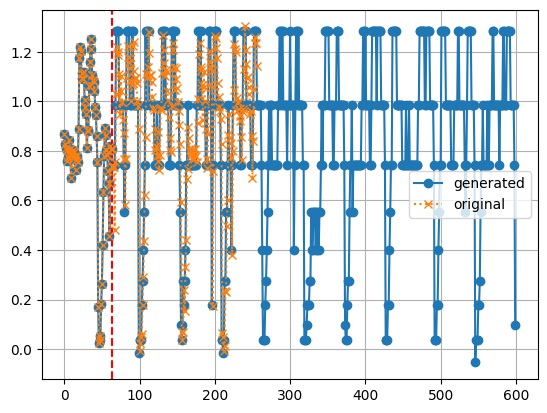

In [12]:
import matplotlib.pyplot as plt

# Generate sequence
prior = prior.cuda()
prior.eval()

num_steps = 600
prime_len = sequence_length // 4

orig_sequence = prior_dataset[randint(0, len(prior_dataset))].cuda()
prime = orig_sequence[:prime_len, :]
sequence = prior.generate(prime, num_steps, 1.0)
latents = sequence.unsqueeze(0)

# Decode to audio
with torch.no_grad():
  # latents, _ = synth.pretrained.encoder.reparametrize(mu, logvar)
  audio = synth.decode(latents.permute(0, 2, 1).to('cpu'))

# display latents
plt.plot(latents.squeeze(0).cpu().numpy()[:,0], label='generated', marker='o')

plt.axvline(x=prime_len-1, color='r', linestyle='--')

plt.plot(orig_sequence.cpu().numpy()[:,0], linestyle=':', label='original', marker='x')
plt.legend()
plt.grid()
# zoom around the prime
margin = 64
# plt.xlim(prime_len-margin, prime_len+margin)
plt.show()

# display audio
audio = audio.cpu().numpy().squeeze()
audio = audio / audio.max()
audio_widget = Audio(audio, rate=fs)
display(audio_widget)

In [ ]:
logits = self.prior_model(prime)
y = self.prior_model.sample(logits, temperature=1.0)[:, -1, :] # @TODO: adjustable temperature

## Export prior model

In [11]:
prior_model_path = os.path.join(models_path_root, f'{prior_model_name}.ts')
!python -m cli.export --model_directory {training_path} --prior_directory {prior_training_path} --output_path {prior_model_path} --type best

print(f'Model saved at {prior_model_path}')

exporting model from checkpoint: /home/btadeusz/code/ddsp_vae/training/seven-manifolds/drums/version_2/checkpoints/best.ckpt
exporting prior model from checkpoint:  /home/btadeusz/code/ddsp_vae/training/seven-manifolds/drums-prior-quantized/best.ckpt
/home/btadeusz/miniconda3/envs/ddsp/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/btadeusz/miniconda3/envs/ddsp/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0

## Others

In [ ]:
# prior.eval()
orig_sequence = prior_dataset[randint(0, len(prior_dataset))].cuda()
slen = 256

x = orig_sequence[:-1]
y = prior._quantizer(prior.normalize(orig_sequence[1:]))

# loss = prior.training_step(x.unsqueeze(0), _)
# print(loss)

y_hat = prior(x.unsqueeze(0)).argmax(dim=-1).squeeze(0)

x = prior._quantizer(prior.normalize(x))


idx = 1

print(f'acc: {(y_hat == y).float().sum() / y_hat.numel()}')
print(f'y[{idx}]: {y[idx]}')
print(f'y_hat[{idx}]: {y_hat[idx]}')

print(f'x[{idx+1}]: {x[idx+1]}')

In [ ]:
x = prior_dataset[randint(0, len(prior_dataset))].cuda().unsqueeze(0)
with torch.no_grad():
  x = next(iter(prior_train_loader))[:, ...]
  print(x.shape)
  print(prior._step(x))

In [24]:
import torch

# Number of steps to generate
num_steps = 10

prior = prior.train().to('cuda')
prior.eval_mode = True

# Initialize the sequence with the given random codes
# sequence = torch.zeros(1, sequence_length, latent_size, device='cuda')

sequence = prior_dataset[101].unsqueeze(0).to('cuda')
norm = prior.normalize(sequence)

# Generate latent codes autoregressively
for i in range(num_steps):
  # Predict the next latent code
  with torch.no_grad():
    logits = prior(sequence[:, -sequence_length:, :])
    next_code = prior.sample(logits=logits, temperature=0.1)

  # Append the predicted code to the sequence and shift the sequence to the right
  sequence = torch.cat((sequence, next_code[:, -1:, :]), dim=1)

mu, logvar = sequence.chunk(2, dim=-1)

In [ ]:
with torch.no_grad():
  display(Audio(dataset[100].cpu().numpy(), rate=fs))
  display(Audio(synth.pretrained(dataset[2].unsqueeze(0).cpu()).squeeze().numpy(), rate=fs))